In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import os

sns.set_style('dark')

%load_ext autotime
%matplotlib inline

BA = 'CISO'
FILE = f"{BA}.csv"
DIRI = "data"
MIN_K = 3
MAX_K = 25 # Assigned because of practicality

if not os.path.exists(f'silhouette_graphs/{BA}'):
    os.mkdir(f'silhouette_graphs/{BA}')

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4 ms


In [142]:
file_path = os.path.join(DIRI, FILE)
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_time             43848 non-null  object
 1   raw demand (MW)       43848 non-null  object
 2   category              43848 non-null  object
 3   cleaned demand (MW)   43848 non-null  int64 
 4   forecast demand (MW)  43848 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
time: 47.3 ms


In [143]:
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW)
0,2015-07-02 00:00:00,38501,OKAY,38501,44804
1,2015-07-02 01:00:00,38528,OKAY,38528,44464
2,2015-07-02 02:00:00,38100,OKAY,38100,43484
3,2015-07-02 03:00:00,37278,OKAY,37278,41565
4,2015-07-02 04:00:00,36698,OKAY,36698,40222
...,...,...,...,...,...
43843,2020-07-01 19:00:00,24945,OKAY,24945,24731
43844,2020-07-01 20:00:00,25296,OKAY,25296,25296
43845,2020-07-01 21:00:00,26065,OKAY,26065,26354
43846,2020-07-01 22:00:00,27033,OKAY,27033,27566


time: 6 ms


In [144]:
# Convert the date string to a pandas datetime
df["date_time"] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df["date"] = df["date_time"].dt.date  # Add separate date string 
df["hour"] = df["date_time"].dt.hour  # Add separate hour string
df

,date_time,raw demand (MW),category,cleaned demand (MW),forecast demand (MW),date,hour
0,2015-07-02 00:00:00,38501,OKAY,38501,44804,2015-07-02,0
1,2015-07-02 01:00:00,38528,OKAY,38528,44464,2015-07-02,1
2,2015-07-02 02:00:00,38100,OKAY,38100,43484,2015-07-02,2
3,2015-07-02 03:00:00,37278,OKAY,37278,41565,2015-07-02,3
4,2015-07-02 04:00:00,36698,OKAY,36698,40222,2015-07-02,4
...,...,...,...,...,...,...,...
43843,2020-07-01 19:00:00,24945,OKAY,24945,24731,2020-07-01,19
43844,2020-07-01 20:00:00,25296,OKAY,25296,25296,2020-07-01,20
43845,2020-07-01 21:00:00,26065,OKAY,26065,26354,2020-07-01,21
43846,2020-07-01 22:00:00,27033,OKAY,27033,27566,2020-07-01,22


time: 39 ms


In [145]:
# Drop all columns except "Cleaned Demand (MW)"
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_demand = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)").copy()
df_demand

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,38501,38528,38100,37278,36698,36637,35513,32654,29826,27799,...,26219,27734,29916,31590,32663,33717,34653,35703,37032,38084
2015-07-03,38874,39362,38901,37774,36246,35561,34302,31760,29105,27038,...,24152,24635,25351,26745,28038,29144,30245,31401,32852,34310
2015-07-04,35519,36452,36746,36125,34843,34109,32991,30902,28528,26609,...,23335,23140,23985,25355,26730,27764,28988,30145,31105,31887
2015-07-05,32703,33125,33206,32732,31490,30676,29545,28679,27265,25666,...,22697,22531,23154,24252,25419,26308,27216,27838,28259,29178
2015-07-06,30418,31285,31817,31803,31181,31055,30257,28294,26116,24355,...,23982,25629,27435,28903,29792,30933,31130,31577,32417,33397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,34811,35792,36137,35442,34454,33236,30809,28386,26312,24772,...,22818,23193,23739,24057,24770,25690,26684,27622,28805,30172
2020-06-28,31571,32760,33337,32669,31656,30372,28291,26189,24389,23083,...,20950,20939,20920,20999,20933,20933,21137,21378,21927,22936
2020-06-29,24288,25522,26492,26860,27017,26635,25040,23495,22544,21768,...,22585,23394,23787,23725,23717,23815,24007,24391,25091,26083


time: 25.1 ms



k =  3 
Magnitude =  166923076115.11252 
Sizes =  [799, 413, 615] 
Silhouetten Score =  0.3900018060441475 
Davies-Bouldin Score =  0.845877878893584

k =  4 
Magnitude =  121075392529.28032 
Sizes =  [791, 473, 315, 248] 
Silhouetten Score =  0.37318974038443564 
Davies-Bouldin Score =  0.8700186326406942

k =  5 
Magnitude =  100814793754.81992 
Sizes =  [341, 266, 707, 346, 167] 
Silhouetten Score =  0.3258401674107956 
Davies-Bouldin Score =  0.9517059637365521

k =  6 
Magnitude =  88522304355.85378 
Sizes =  [419, 231, 243, 596, 174, 164] 
Silhouetten Score =  0.2943281162051126 
Davies-Bouldin Score =  1.0307481041976676

k =  7 
Magnitude =  80752397799.86533 
Sizes =  [222, 288, 224, 157, 475, 304, 157] 
Silhouetten Score =  0.27305984356534496 
Davies-Bouldin Score =  1.0826619247262117

k =  8 
Magnitude =  74202497715.7924 
Sizes =  [453, 165, 288, 175, 292, 98, 199, 157] 
Silhouetten Score =  0.25258472466743837 
Davies-Bouldin Score =  1.1386698490959548

k =  9 
Magnitu

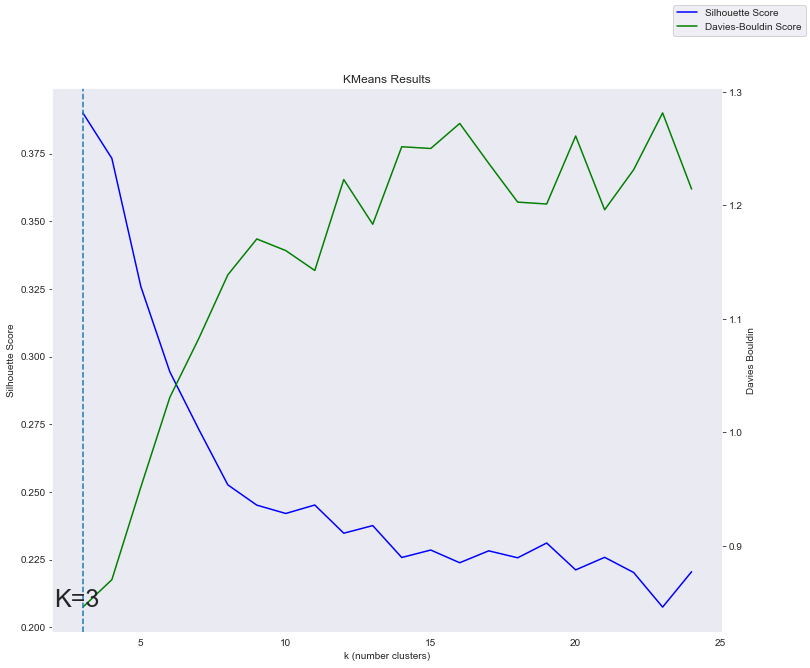

time: 6.69 s


In [146]:
# Save cluster magnitudes (sum of sqaured distances to the centroid) in a dataframe
# where index = number of clusters
#

# .inertia_ returns the sum of squared distances of samples to their closest cluster center
# .cluster_centers_  returns array wuth coordinates of cluster centers
# .labels_ returns the cluster label of each example in order

cluster_stats = pd.DataFrame(index=range(MIN_K, MAX_K), columns=["Magnitude", "Silhouette", "DB"])

for k in cluster_stats.index:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_demand)
    clusters = kmeans.labels_
    cluster_stats["Magnitude"][k] = kmeans.inertia_
    
    # For each cluster label, find how many examples are part of that cluster
    cluster_sizes = []
    for i in range(k):
        cluster_sizes.append(len(np.where(clusters == i)[0]))

    # Calculate the average Silhouette Score for each cluster
    cluster_stats['Silhouette'][k] = silhouette_score(df_demand, kmeans.labels_)

    # Davies Boulding score
    cluster_stats['DB'][k] = davies_bouldin_score(df_demand, kmeans.labels_)
    
    print("\nk = ", k,
     "\nMagnitude = ", kmeans.inertia_,
     "\nSizes = ", cluster_sizes, 
     "\nSilhouetten Score = ", cluster_stats['Silhouette'][k], 
     "\nDavies-Bouldin Score = ", cluster_stats['DB'][k])
    

fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title("KMeans Results")
ax.plot(cluster_stats['Silhouette'], color='blue', label='Silhouette Score')
ax.set_xlabel("k (number clusters)")
ax.set_ylabel("Silhouette Score")

ax2 = ax.twinx()
ax2.plot(cluster_stats['DB'], color='green', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies Bouldin')

ax2.axvline(x=MIN_K+np.argmin(cluster_stats['DB']), linestyle='--')
ax2.text(MIN_K+np.argmin(cluster_stats['DB'])-1,
 np.min(cluster_stats['DB']),
 f"K={MIN_K+np.argmin(cluster_stats['DB'])}", 
 fontsize=25)

fig.legend()

fig.savefig(f"silhouette_graphs/{BA}/kmeans_results", facecolor='white', transparent=False)

cluster_stats.to_csv(f"kmeans_results")

C:\Users\jimpg\AppData\Local\Temp/ipykernel_1916/432582791.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_silho = pd.Series(index=range(3, MAX_K))


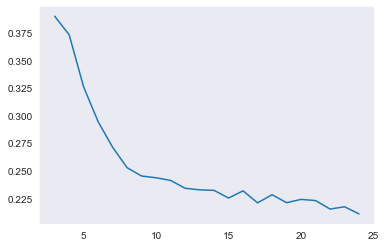

time: 11.1 s


In [147]:
# Perform silhouette analysis on a point-by-point basis
avg_silho = pd.Series(index=range(3, MAX_K))

for k in range(3, MAX_K):
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(df_demand)

    silhouette_avg = silhouette_score(df_demand, cluster_labels)
    sample_silhouette_values = silhouette_samples(df_demand, cluster_labels)

    avg_silho[k] = silhouette_avg

    y_lower = 10
    for i in range(k): # for each cluster created
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples


    plt.title(f"Silhouette Coefficients for All Points, k={k}")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.savefig(f"silhouette_graphs/{BA}/kmeans_silhouette_{k}.png", facecolor='white', transparent=False)
    plt.close()

plt.plot(avg_silho)

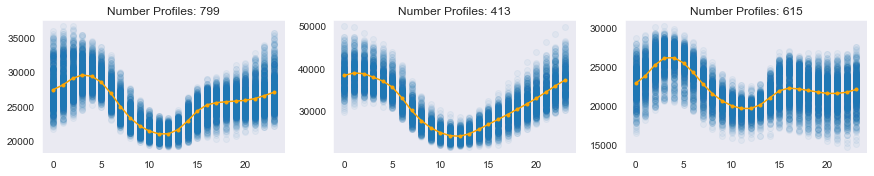

time: 670 ms


In [148]:
from matplotlib.gridspec import GridSpec

chosen_k = cluster_stats.loc[cluster_stats['DB'] == cluster_stats['DB'].min()].index[0]

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)

kmeans = KMeans(n_clusters=chosen_k, random_state=0).fit(df_demand)
clusters = kmeans.labels_
df_demand["profile_cluster"] = clusters

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids = centroids.T

for k in range(chosen_k):
    df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == k].reset_index()
    df_cluster_loads.drop("profile_cluster", axis=1, inplace=True)
    df_cluster_loads = df_cluster_loads.melt(id_vars="date")
    ax = fig.add_subplot(gs[k])
    ax.scatter(df_cluster_loads["hour"], df_cluster_loads["value"], alpha=0.05)
    ax.plot(centroids[k][0:24], '.-', color='orange')

    ax.set_title(f'Number Profiles: {len(df_demand.loc[df_demand["profile_cluster"] == k])}')


fig.savefig(f'silhouette_graphs/{BA}/kmeans_{chosen_k}_load_profiles', facecolor='white', transparent=False)

Let's figure out what kind of day each cluster represents.

In [149]:
def is_weekday(x):
    if x < 5:
        return True
    else:
        return False
    
    
def season_name(x):
    if x == 1:
        return "Winter"
    if x == 2:
        return "Spring"
    if x == 3:
        return "Summer"
    if x == 4:
        return "Fall"

print('nO eRROS!~!')

nO eRROS!~!
time: 1e+03 µs


In [150]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
df_demand.index = pd.to_datetime(df_demand.index)

df_demand["weekday"] = df_demand.index.dayofweek
df_demand["season num"] = df_demand.index.month%12 // 3 + 1

df_demand["is weekday"] = df_demand["weekday"].apply(lambda x: is_weekday(x))
df_demand["season"] = df_demand["season num"].apply(lambda x: season_name(x))

df_clusters = df_demand[["profile_cluster", "is weekday", "season", "season num"]]
df_clusters.columns = ["profile_cluster", "is weekday", "season", "season num"]

for k in range(MAX_K):
    dfk = df_clusters.loc[df_clusters["profile_cluster"] == k]
    print(dfk.value_counts())

profile_cluster  is weekday  season  season num
0                True        Fall    4             219
                             Winter  1             218
                             Spring  2             155
                             Summer  3              82
                 False       Fall    4              51
                             Summer  3              48
                             Winter  1              16
                             Spring  2              10
dtype: int64
profile_cluster  is weekday  season  season num
1                True        Summer  3             244
                             Fall    4              73
                 False       Summer  3              71
                             Fall    4              19
                 True        Spring  2               6
dtype: int64
profile_cluster  is weekday  season  season num
2                True        Spring  2             168
                 False       Spring  2             121
     

In [151]:
def cluster_similarity(x, centroid):
    # input is all rows belonging to a cluster
    total = 0
    
    for row in range(len(x)):
        for hour in range(23):
            # absolute diff between centroid hourly load and actual
            total += abs(x[hour][row] - centroid[hour])
    
    return total/len(x)

time: 998 µs


In [152]:
df_dropped = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_loads = df_dropped.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)").copy()
df_loads["profile_cluster"] = clusters
df_loads

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,profile_cluster
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,38501,38528,38100,37278,36698,36637,35513,32654,29826,27799,...,27734,29916,31590,32663,33717,34653,35703,37032,38084,1
2015-07-03,38874,39362,38901,37774,36246,35561,34302,31760,29105,27038,...,24635,25351,26745,28038,29144,30245,31401,32852,34310,1
2015-07-04,35519,36452,36746,36125,34843,34109,32991,30902,28528,26609,...,23140,23985,25355,26730,27764,28988,30145,31105,31887,1
2015-07-05,32703,33125,33206,32732,31490,30676,29545,28679,27265,25666,...,22531,23154,24252,25419,26308,27216,27838,28259,29178,0
2015-07-06,30418,31285,31817,31803,31181,31055,30257,28294,26116,24355,...,25629,27435,28903,29792,30933,31130,31577,32417,33397,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,34811,35792,36137,35442,34454,33236,30809,28386,26312,24772,...,23193,23739,24057,24770,25690,26684,27622,28805,30172,0
2020-06-28,31571,32760,33337,32669,31656,30372,28291,26189,24389,23083,...,20939,20920,20999,20933,20933,21137,21378,21927,22936,0
2020-06-29,24288,25522,26492,26860,27017,26635,25040,23495,22544,21768,...,23394,23787,23725,23717,23815,24007,24391,25091,26083,0


time: 27.1 ms


In [153]:
cluster_sims = []
for k in range(chosen_k):    
    input_x = df_loads.loc[kmeans.labels_ == k].reset_index()
    cluster_sims.append(cluster_similarity(input_x, centroids[k]))
    print(f"\nCluster {k}:", cluster_sims[k])


Cluster 0: 29624.02020003216

Cluster 1: 44469.44703902826

Cluster 2: 30489.898099444406
time: 295 ms


In [154]:
df_clusters['year'] = df_clusters.index.year
df_clusters['day of year'] = df_clusters.index.dayofyear

dset = df_clusters.copy()
dset = dset.reset_index()
dset = dset.melt(id_vars=["year", "day of year"], value_vars='profile_cluster')

dset

C:\Users\jimpg\AppData\Local\Temp/ipykernel_1916/2624806095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['year'] = df_clusters.index.year
C:\Users\jimpg\AppData\Local\Temp/ipykernel_1916/2624806095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['day of year'] = df_clusters.index.dayofyear


,year,day of year,variable,value
0,2015,183,profile_cluster,1
1,2015,184,profile_cluster,1
2,2015,185,profile_cluster,1
3,2015,186,profile_cluster,0
4,2015,187,profile_cluster,0
...,...,...,...,...
1822,2020,179,profile_cluster,0
1823,2020,180,profile_cluster,0
1824,2020,181,profile_cluster,0
1825,2020,182,profile_cluster,0


time: 12 ms


In [155]:
# dset used to represent cluster for everyday over dataset
dset.rename(columns = {"value":"cluster"}, inplace=True)
dset = dset.pivot(index="year", columns="day of year", values="cluster")
dset

day of year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,NaN
2016,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0
2017,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,NaN
2018,2.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
2019,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,...,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,NaN
2020,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 19 ms


In [156]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
# NOTE: Monday = 0
def day_type_calc(season, weekday):
    # Weekdays
    if weekday:
        return season
    # Weekends
    else:
        return season + 4

print('nO eRRORS!')



nO eRRORS!
time: 1.34 ms


In [157]:
df_clusters["day type"] = df_clusters["season num"] + df_clusters["is weekday"]*4
df_clusters

C:\Users\jimpg\AppData\Local\Temp/ipykernel_1916/251835812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters["day type"] = df_clusters["season num"] + df_clusters["is weekday"]*4


,profile_cluster,is weekday,season,season num,year,day of year,day type
date,,,,,,,
2015-07-02,1,True,Summer,3,2015,183,7
2015-07-03,1,True,Summer,3,2015,184,7
2015-07-04,1,False,Summer,3,2015,185,3
2015-07-05,0,False,Summer,3,2015,186,3
2015-07-06,0,True,Summer,3,2015,187,7
...,...,...,...,...,...,...,...
2020-06-27,0,False,Summer,3,2020,179,3
2020-06-28,0,False,Summer,3,2020,180,3
2020-06-29,0,True,Summer,3,2020,181,7


time: 10 ms


In [158]:
df_clusters

,profile_cluster,is weekday,season,season num,year,day of year,day type
date,,,,,,,
2015-07-02,1,True,Summer,3,2015,183,7
2015-07-03,1,True,Summer,3,2015,184,7
2015-07-04,1,False,Summer,3,2015,185,3
2015-07-05,0,False,Summer,3,2015,186,3
2015-07-06,0,True,Summer,3,2015,187,7
...,...,...,...,...,...,...,...
2020-06-27,0,False,Summer,3,2020,179,3
2020-06-28,0,False,Summer,3,2020,180,3
2020-06-29,0,True,Summer,3,2020,181,7


time: 8 ms


day of year,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
2015,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,-1.0
2016,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,...,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0
2017,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,...,1.0,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,-1.0
2018,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,...,1.0,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,-1.0
2019,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,1.0,1.0,5.0,5.0,-1.0
2020,5.0,5.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


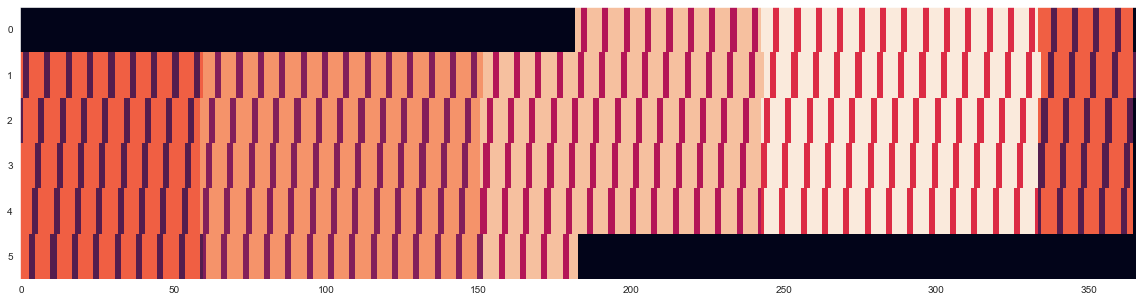

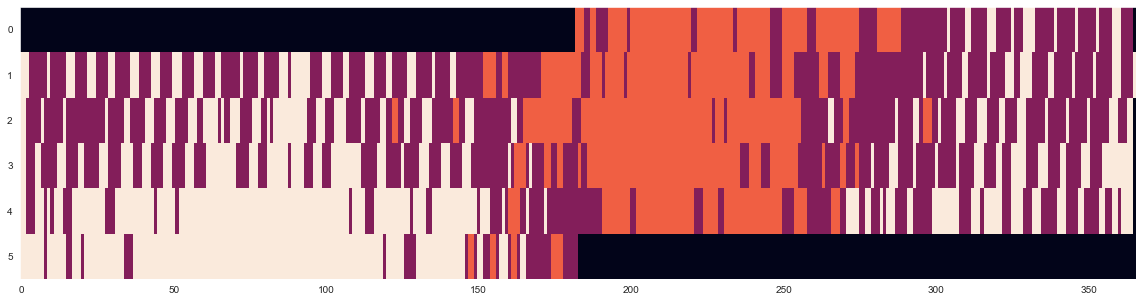

time: 340 ms


In [159]:
day_type = df_clusters[["day type", "year", "day of year"]]
day_type = day_type.pivot(index = "year", columns = "day of year", values = "day type")
day_type.fillna(-1, inplace=True)

plt.figure(figsize=(20, 5))
plt.imshow(day_type, aspect='auto')

dset.fillna(-1, inplace=True)
plt.figure(figsize=(20, 5))
plt.imshow(dset, aspect='auto')
day_type

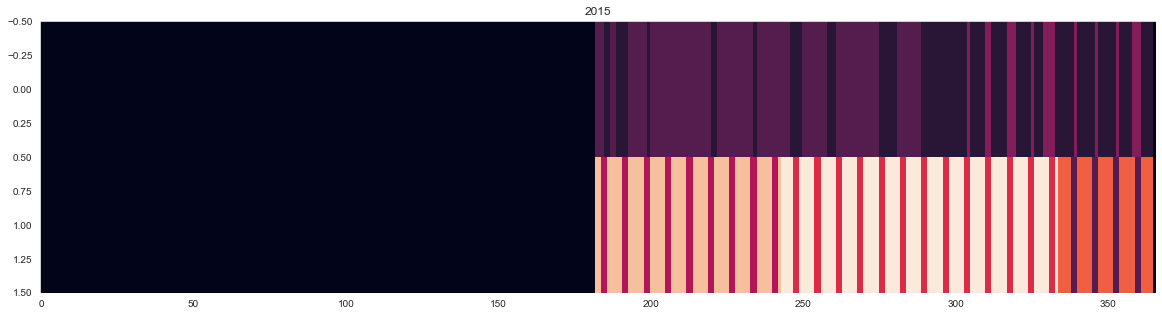

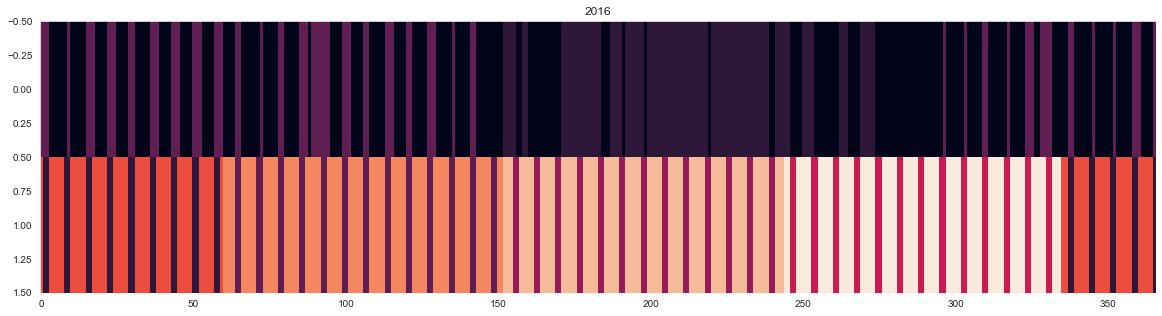

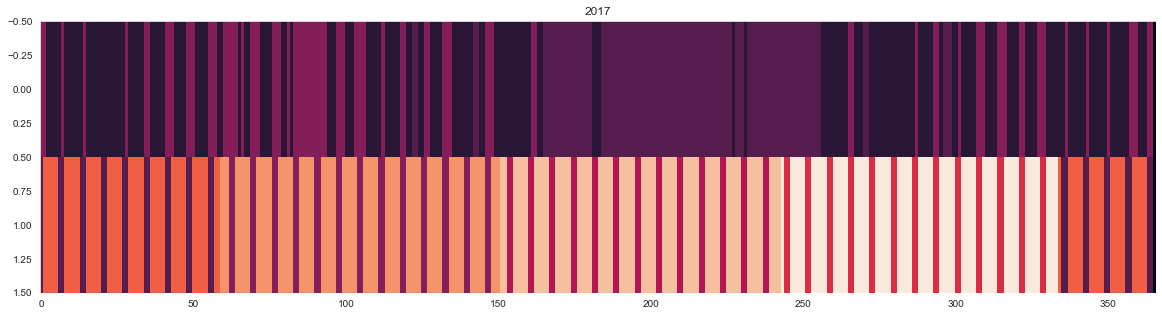

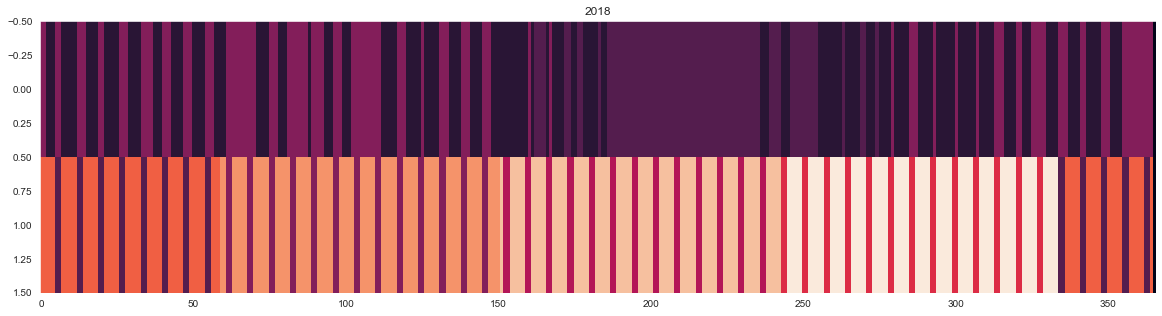

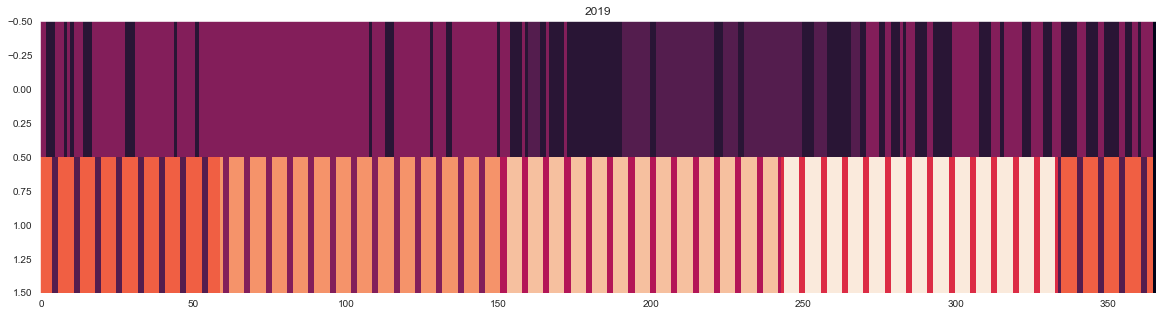

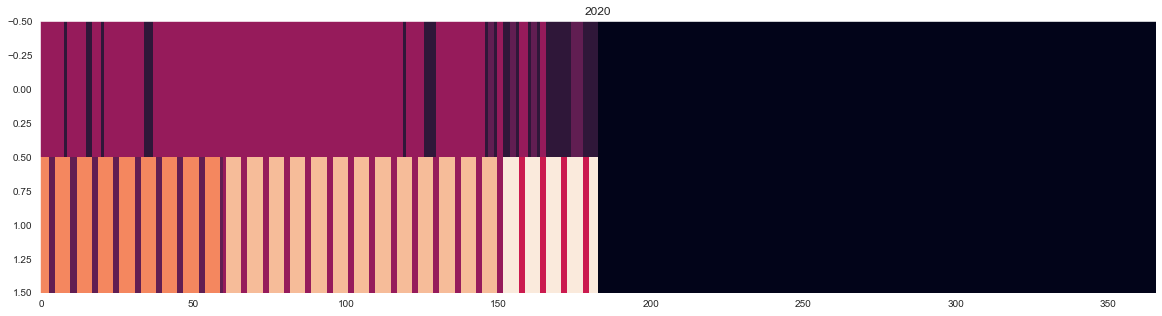

time: 1.47 s


In [160]:
for year in dset.index:
    dset_temp = dset.loc[dset.index == year].reset_index().drop('year', axis=1)
    dset_temp = dset_temp.append(day_type.loc[day_type.index == year].reset_index().drop('year', axis=1))
    plt.figure(figsize=(20, 5))
    plt.imshow(dset_temp, aspect='auto')
    plt.title(year)
    plt.savefig(f'silhouette_graphs/{BA}/spectrograph_{year}', facecolor='white', transparent=False)

In [162]:
# NOTE: 1 = WINTER, 2 = SPRING, 3 = SUMMER, 4 = FALL
def reverse_day_type_calc(day_type):
    # Weekdays
    if day_type == 1:
        return 'Winter Weekday'
    if day_type == 2:
        return 'Spring Weekday'
    if day_type == 3:
        return 'Summer Weekday'
    if day_type == 4:
        return 'Fall Weekday'
    if day_type == 5:
        return 'Winter Weekend'
    if day_type == 6:
        return 'Spring Weekend'
    if day_type == 7:
        return 'Summer Weekend'
    if day_type == 8:
        return 'Fall Weekend'

print('nO eRRORS!')

nO eRRORS!
time: 1 ms


In [163]:
cluster_spread = df_clusters.groupby(['day type'])['profile_cluster'].value_counts()
cluster_spread = pd.DataFrame(cluster_spread)
cluster_spread.columns = ['count']
cluster_spread.reset_index(inplace=True)

for i in range(1, 9):
    max_cluster = cluster_spread[['count', 'profile_cluster']].loc[cluster_spread['day type']  == i]
    max_cluster = max_cluster.loc[max_cluster['count'] == max_cluster['count'].max()]
    print(f"Most Frequent Cluster for {reverse_day_type_calc(i)}:", max_cluster['profile_cluster'].values)

Most Frequent Cluster for Winter Weekday: [2]
Most Frequent Cluster for Spring Weekday: [2]
Most Frequent Cluster for Summer Weekday: [1]
Most Frequent Cluster for Fall Weekday: [2]
Most Frequent Cluster for Winter Weekend: [0]
Most Frequent Cluster for Spring Weekend: [2]
Most Frequent Cluster for Summer Weekend: [1]
Most Frequent Cluster for Fall Weekend: [0]
time: 14 ms


In [164]:
df_cluster_loads

,date,hour,value
0,2015-11-01,0,26583
1,2015-11-07,0,25427
2,2015-11-08,0,22530
3,2015-11-14,0,25733
4,2015-11-15,0,22470
...,...,...,...
14755,2020-06-06,23,19941
14756,2020-06-07,23,18189
14757,2020-06-08,23,23955
14758,2020-06-13,23,22035


time: 5.44 ms


C:\Users\jimpg\AppData\Local\Temp/ipykernel_1916/2330728187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters['day name'] = df_clusters['day type'].map(reverse_day_type_calc)


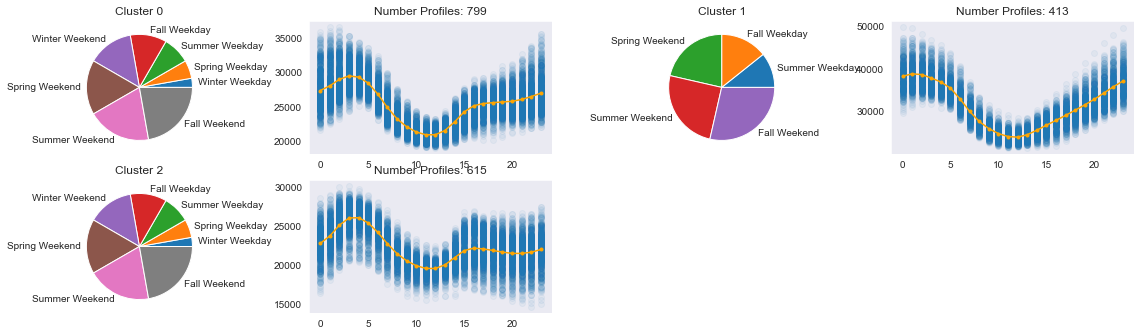

time: 597 ms


In [166]:
df_clusters['day name'] = df_clusters['day type'].map(reverse_day_type_calc)
cluster_spread = df_clusters.groupby(['day type', 'day name'])['profile_cluster'].value_counts()
cluster_spread = pd.DataFrame(cluster_spread)
cluster_spread.columns = ['count']
cluster_spread.reset_index(inplace=True)

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)


for (graph_idx, cluster) in zip(range(0, chosen_k*2, 2), range(chosen_k)):
    max_cluster = cluster_spread[['day type', 'count', 'day name']].loc[cluster_spread['profile_cluster']  == cluster]
    # max_cluster = max_cluster.loc[max_cluster['count'] == max_cluster['count'].max()]
    # print(f"Most Frequent Day Type for Cluster {i}:", reverse_day_type_calc(max_cluster['day type'].values))

    ax = fig.add_subplot(gs[graph_idx])
    ax.pie(max_cluster['day type'], labels=max_cluster['day name'])
    ax.set_title(f'Cluster {cluster}')


    ax = fig.add_subplot(gs[graph_idx+1])

    df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == cluster].reset_index()
    df_cluster_loads.drop(["profile_cluster", "weekday", "season num", "is weekday", "season"], axis=1, inplace=True)
    df_cluster_loads = df_cluster_loads.melt(id_vars="date")
    ax.scatter(df_cluster_loads["hour"], df_cluster_loads["value"], alpha=0.05)
    ax.plot(centroids[cluster][0:24], '.-', color='orange')
    ax.set_title(f'Number Profiles: {len(df_demand.loc[df_demand["profile_cluster"] == cluster])}')
    ax.set_ylabel('MW')
    ax.set_xlabel('Hour of Day')

fig.savefig(f'silhouette_graphs/{BA}/all_clusters_analysis', facecolor='white', transparent=False)

In [ ]:
df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == 1].reset_index()
df_cluster_loads


hour,date,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,profile_cluster,weekday,season num,is weekday,season
0,2015-07-27,2335,2390,2391,2380,2351,2334,2186,1994,1859,...,2604,2632,2664,2683,2691,1,0,3,True,Summer
1,2015-08-31,2333,2360,2366,2342,2411,2303,2120,1959,1802,...,2585,2643,2675,2643,2655,1,0,3,True,Summer
2,2015-09-04,2452,2419,2415,2433,2488,2380,2169,1977,1853,...,2434,2427,2438,2422,2406,1,4,4,True,Fall
3,2015-09-08,2336,2414,2413,2441,2499,2353,2125,1909,1792,...,2594,2646,2685,2753,2793,1,1,4,True,Fall
4,2015-09-14,2504,2516,2464,2492,2464,2318,2094,1926,1778,...,2476,2471,2466,2451,2416,1,0,4,True,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,2020-06-18,2326,2368,2394,2356,2303,2268,2143,1950,1808,...,2258,2306,2351,2374,2430,1,3,3,True,Summer
392,2020-06-22,2251,2311,2343,2336,2293,2260,2126,1928,1773,...,2384,2475,2539,2608,2694,1,0,3,True,Summer
393,2020-06-29,2152,2220,2250,2224,2184,2153,2035,1868,1737,...,2329,2358,2358,2376,2399,1,0,3,True,Summer
394,2020-06-30,2460,2502,2498,2434,2357,2306,2175,1968,1831,...,2350,2382,2361,2347,2366,1,1,3,True,Summer


time: 39.6 ms


In [ ]:
centroids

,0,1,2,3,4,5,6,7,8
0,2591.915751,2307.547980,3064.385965,2642.267925,2390.100962,3531.781250,3118.426471,2771.766497,2258.043290
1,2681.432234,2346.780303,3186.245614,2689.841509,2445.355769,3584.156250,3164.735294,2879.639594,2282.956710
2,2816.963370,2368.608586,3373.649123,2699.041509,2520.360577,3550.796875,3136.250000,3034.563452,2286.341991
3,2842.978022,2375.760101,3396.614035,2648.750943,2568.480769,3445.156250,3038.095588,3064.380711,2267.961039
4,2788.190476,2358.047980,3334.596491,2580.233962,2553.504808,3323.734375,2934.985294,3011.441624,2240.640693
5,2698.260073,2264.058081,3237.157895,2487.324528,2431.091346,3165.921875,2791.014706,2922.791878,2173.800866
6,2543.842491,2079.053030,3058.245614,2300.969811,2232.639423,2861.984375,2533.095588,2754.827411,2034.519481
7,2341.597070,1889.878788,2814.350877,2092.566038,2038.798077,2546.234375,2267.492647,2531.197970,1873.212121
8,2157.120879,1758.840909,2604.508772,1922.683019,1905.221154,2299.765625,2060.029412,2329.076142,1739.536797
9,2030.908425,1683.196970,2467.280702,1808.743396,1829.413462,2131.421875,1924.051471,2194.888325,1653.155844


time: 22.3 ms
